In [1]:
import pandas as pd
from datetime import date
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import urllib.request
import codecs
pd.options.display.max_rows=1000
%matplotlib inline

## I. Data Extraction

In [2]:
#Copy desired dates from website: http://web.mta.info/developers/turnstile.html
raw_dates_txt = """
Saturday, June 29, 2019
Saturday, June 22, 2019
Saturday, June 15, 2019
Saturday, June 08, 2019
Saturday, June 01, 2019
"""

In [3]:
date_obj_lst = [datetime.strftime(datetime.strptime(line, '%A, %B %d, %Y'), '%y%m%d') for line in raw_dates_txt.split('\n') if line]
    
turnstile_url = ['http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + date + '.txt' for date in date_obj_lst]

with open('turnstile_data', 'w') as outfile:
    writer = csv.writer(outfile, delimiter=',')
    ftpstream = urllib.request.urlopen(turnstile_url[0])
    csvfile = csv.reader(codecs.iterdecode(ftpstream, 'utf-8'))
    for line in csvfile:
        writer.writerow(line)    
    for url in turnstile_url[1:]:
        ftpstream = urllib.request.urlopen(url)
        csvfile = csv.reader(codecs.iterdecode(ftpstream, 'utf-8'))
        firstline = True
        for line in csvfile:
            if firstline:    #skip first line
                firstline = False
                continue
            writer.writerow(line)

In [4]:
with open('turnstile_data') as input:
    turnstile = pd.read_csv(input)

In [3]:
turnstile.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173


In [5]:
turnstile.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [227]:
turnstile.isna().sum()

C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [166]:
turnstile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413440 entries, 0 to 413439
Data columns (total 11 columns):
C/A                                                                     413440 non-null object
UNIT                                                                    413440 non-null object
SCP                                                                     413440 non-null object
STATION                                                                 413440 non-null object
LINENAME                                                                413440 non-null object
DIVISION                                                                413440 non-null object
DATE                                                                    413440 non-null object
TIME                                                                    413440 non-null object
DESC                                                                    413440 non-null object
ENTRIES                           

## II. Data Cleansing

### 1. Clean Column Names

In [6]:
turnstile.columns=[col.strip() for col in turnstile.columns]
turnstile.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

### 2. Remove Inconsistent Text

In [7]:
#station name cleansing
#the strip() removes characters from both left and right based on the argument
turnstile['STATION']=[name.strip() for name in turnstile.STATION]
turnstile['STATION'] = turnstile['STATION'].str.replace('STREET', 'ST')
turnstile['STATION'] = turnstile['STATION'].str.replace('AVE', 'AV')

### 3. Change DataType to DateTime

In [8]:
turnstile['DATE & TIME']=turnstile['DATE'] +' '+ turnstile['TIME']
turnstile.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE & TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,00:00:00,REGULAR,7107725,2407457,06/22/2019 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,04:00:00,REGULAR,7107738,2407465,06/22/2019 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,08:00:00,REGULAR,7107761,2407491,06/22/2019 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,12:00:00,REGULAR,7107858,2407541,06/22/2019 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,16:00:00,REGULAR,7108075,2407581,06/22/2019 16:00:00


In [9]:
turnstile['DATE & TIME'] = pd.to_datetime(turnstile['DATE & TIME'])

In [10]:
turnstile['DAY OF WEEK']=turnstile['DATE & TIME'].dt.day_name()

### 4. Data Disaggregation 

In [11]:
#Since the entry data we have is cumulative, 
#we want to combine ControlArea/UNIT/STATION together
#and calculate the actual numbers of entries per turnstile
#for each day, add the counts from each turnstile belonging to that combo.
turnstile['ENTRIES DIFF']=turnstile.groupby(['C/A','UNIT','STATION'])['ENTRIES'].diff()
turnstile['EXITS DIFF']=turnstile.groupby(['C/A','UNIT','STATION'])['EXITS'].diff()

In [174]:
#check how many nan and negative entry numbers do we have in total
turnstile[(turnstile['ENTRIES DIFF']<0) | (turnstile['EXITS DIFF']<0)].count()

C/A             10754
UNIT            10754
SCP             10754
STATION         10754
LINENAME        10754
DIVISION        10754
DATE            10754
TIME            10754
DESC            10754
ENTRIES         10754
EXITS           10754
DATE & TIME     10754
DAY OF WEEK     10754
ENTRIES DIFF    10754
EXITS DIFF      10754
dtype: int64

In [175]:
turnstile.isna().sum()

C/A               0
UNIT              0
SCP               0
STATION           0
LINENAME          0
DIVISION          0
DATE              0
TIME              0
DESC              0
ENTRIES           0
EXITS             0
DATE & TIME       0
DAY OF WEEK       0
ENTRIES DIFF    746
EXITS DIFF      746
dtype: int64

In [12]:
#The total number of negative entries and na entries 
#is small, so we can drop them
turnstile=turnstile.drop(turnstile[turnstile['ENTRIES DIFF'] < 0].index)
turnstile=turnstile.drop(turnstile[turnstile['EXITS DIFF'] < 0].index)
turnstile=turnstile.dropna()

In [13]:
#We can now remove the culmulative entries and exits data
turnstile=turnstile.drop(['ENTRIES','EXITS'],axis=1)

### 5. Remove Outliners

In [236]:
turnstile.describe()

,ENTRIES DIFF,EXITS DIFF
count,7.852530e+05,7.852530e+05
mean,7.553194e+05,6.394294e+05
std,3.006507e+07,2.733767e+07
min,0.000000e+00,0.000000e+00
25%,1.000000e+01,8.000000e+00
50%,7.500000e+01,5.300000e+01
75%,2.440000e+02,1.690000e+02
max,2.122126e+09,2.118643e+09


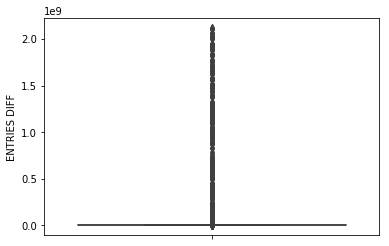

In [179]:
sns.boxplot(turnstile['ENTRIES DIFF'],orient='v')

In [14]:
q25_1,q50_1,q75_1=np.percentile(turnstile['ENTRIES DIFF'],[25,50,75])
iqr_1=q75_1-q25_1
iqr_1

232.0

In [15]:
q25_2,q50_2,q75_2=np.percentile(turnstile['EXITS DIFF'],[25,50,75])
iqr_2=q75_2-q25_2
iqr_2

162.0

In [16]:
max_entry=q75_1+1.5*(iqr_1)
max_exit=q75_2+1.5*(iqr_2)

In [17]:
#calculate how many outliner do we have in entry data
turnstile[turnstile['ENTRIES DIFF']> max_entry].count()

C/A             73367
UNIT            73367
SCP             73367
STATION         73367
LINENAME        73367
DIVISION        73367
DATE            73367
TIME            73367
DESC            73367
DATE & TIME     73367
DAY OF WEEK     73367
ENTRIES DIFF    73367
EXITS DIFF      73367
dtype: int64

In [18]:
#calculate how many outliner do we have in exit data
turnstile[turnstile['EXITS DIFF']> max_exit].count()

C/A             90133
UNIT            90133
SCP             90133
STATION         90133
LINENAME        90133
DIVISION        90133
DATE            90133
TIME            90133
DESC            90133
DATE & TIME     90133
DAY OF WEEK     90133
ENTRIES DIFF    90133
EXITS DIFF      90133
dtype: int64

In [19]:
turnstile=turnstile.drop(turnstile[turnstile['ENTRIES DIFF']>max_entry].index)
turnstile=turnstile.drop(turnstile[turnstile['EXITS DIFF']>max_exit].index)

### 6. Add WEEK OF THE YEAR column

In [20]:
turnstile['WEEK OF YEAR']=turnstile['DATE & TIME'].dt.week
turnstile['YEAR']=turnstile['DATE & TIME'].dt.year

In [21]:
turnstile.groupby(['WEEK OF YEAR','YEAR'])['EXITS DIFF'].sum()

WEEK OF YEAR  YEAR
21            2019     3334794.0
22            2019    12998001.0
23            2019    13567677.0
24            2019    13417324.0
25            2019    13516741.0
26            2019    10320730.0
Name: EXITS DIFF, dtype: float64

## III. Data Analysis/Visualization

1. Total Daily Entries per DAY OF WEEK

From the result, we can have a general idea about which
day of the week have the most total entries. 

In [186]:
turnstile.groupby(['DATE'])['ENTRIES DIFF']\
     .sum()\
     .reset_index(name='TOTAL ENTRIES per DAY')\
     .sort_values(['TOTAL ENTRIES per DAY'], ascending=False)

,DATE,TOTAL ENTRIES per DAY
6,06/21/2019,3185693.0
13,06/28/2019,3157133.0
12,06/27/2019,3080544.0
11,06/26/2019,3048125.0
10,06/25/2019,3047638.0
5,06/20/2019,3045272.0
3,06/18/2019,3038022.0
4,06/19/2019,3016468.0
9,06/24/2019,2986984.0
2,06/17/2019,2920861.0


2. Total Entries per Station

This gives us an idea of which stations are the top 10 most busiest stations. 

Need a plot here

In [90]:
turnstile.groupby(['STATION'])['ENTRIES DIFF']\
     .sum()\
     .reset_index(name='TOTAL ENTRIES per Station')\
     .sort_values(['TOTAL ENTRIES per Station'], ascending=False)\
     .head(10)

,STATION,TOTAL ENTRIES per Station
61,34 ST-PENN STA,2216636.0
46,23 ST,1597704.0
225,FULTON ST,1550122.0
110,86 ST,1368363.0
9,125 ST,1173027.0
68,42 ST-PORT AUTH,1171630.0
85,59 ST,1067096.0
172,CANAL ST,1050645.0
352,TIMES SQ-42 ST,1021838.0
124,ATL AV-BARCLAY,1008110.0


3. Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [80]:
df=turnstile.groupby(['STATION','DAY OF WEEK'])['ENTRIES DIFF']\
     .sum()\
     .reset_index(name='TOTAL ENTRIES per DAY')

In [94]:
station_day = ['STATION', 'DAY OF WEEK']
station_day_df = (df.set_index(week_day)  
                           .sort_index()
                           .sort_values(['TOTAL ENTRIES per DAY'], ascending=False))
station_day_df.head()

TOTAL ENTRIES per DAY
STATION        DAY OF WEEK                       
34 ST-PENN STA Friday                    343617.0
               Monday                    333018.0
               Tuesday                   320301.0
               Wednesday                 317507.0
               Thursday                  316144.0

In [93]:
from pylab import rcParams
# rcParams['figure.figsize'] = 5, 10
# station_day_df.unstack(level=0).plot(kind='line',figsize=(100, 100), subplots=True);

In [115]:
df_34_ST_PENN_STA = station_day_df.loc['34 ST-PENN STA']
df_23_ST = station_day_df.loc['23 ST']
df_FULTON_ST = station_day_df.loc['FULTON ST']
df_86_ST = station_day_df.loc['86 ST']
df_125_ST = station_day_df.loc['125 ST']
df_42_ST_PORT_AUTH = station_day_df.loc['42 ST-PORT AUTH']

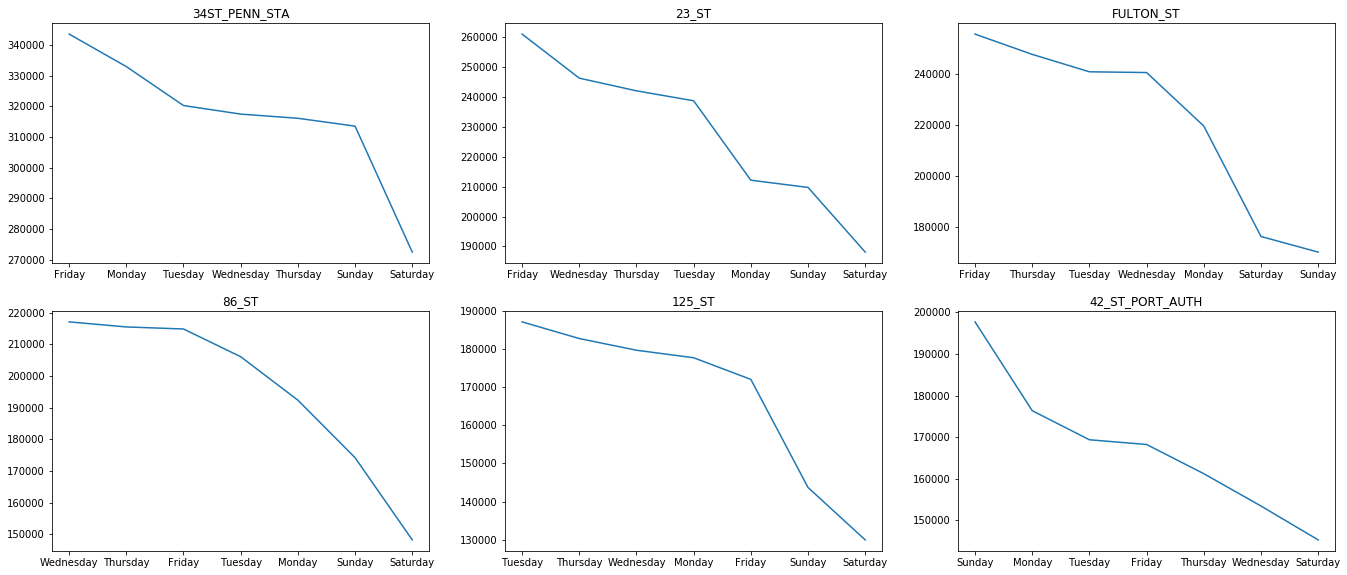

In [136]:
plt.figure(figsize=[23,15])
plt.subplot(3,3,1)
plt.plot(df_34ST_PENN_STA)
plt.title('34ST_PENN_STA')

plt.subplot(3,3,2)
plt.plot(df_23_ST)
plt.title('23_ST')

plt.subplot(3,3,3)
plt.plot(df_FULTON_ST)
plt.title('FULTON_ST')

plt.subplot(3,3,4)
plt.plot(df_86_ST)
plt.title('86_ST')

plt.subplot(3,3,5)
plt.plot(df_125_ST)
plt.title('125_ST')

plt.subplot(3,3,6)
plt.plot(df_42_ST_PORT_AUTH)
plt.title('42_ST_PORT_AUTH');
#Question: Is it possible to change the x axis to be the same for each graph. or is it 